In this notebook, I try out different time series models, specifically focusing on using neural nets on my time series data.<br/>

I'll be using this primarily as a guide: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Table of Contents
1. [Imports](#section1)
2. [Load in Data](#section2)
3. [LSTM Time Series](#section3)

<a id='section1'></a>

### 1. Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
# neural net imports; need to be on Tensorflow kernel

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Input, Embedding, Bidirectional, LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tensorflow/l

<a id='section2'></a>

### 2. Load in Data

In [3]:
park_df = pd.read_pickle('data/park_df.pickle')

<a id='section3'></a>

### 3. LSTM Time Series

Following this and building an LSTM model for univariate time series forecasting. Once I build all my different models, I would like to compare them against once another, looking at metrics (probably mean squared error) to pick the best model.

Prep the data for a neural net. Given a sequence like [10, 20, 30, 40, 50], I want to transform the data into something like <br/>

|X|Y|
|---|---|
|10, 20, 30|40|
|20, 30, 40|50|

In [6]:
# first, prepare the data for a neural net

def split_data(data, n_steps):
    '''
    This function splits a univariate time series into sample sequences. For example, 
    given a sequence like [10, 20, 30, 40, 50] and a step size of 3, split the data into
    X: [10, 20, 30] and [20, 30, 40]
    Y: [40] and [50]
    
    Parameters:
    -----------
    - data: the full data to split into sample sequences
    - n-steps: number of data points per sequence
    
    Returns:
    ---------
    - x, y: arrays with the data split into sample sequences
    '''
    
    x, y = list(), list()
    for i in range(len(data)-n_steps):
        seq_x = data[i:i+n_steps]
        seq_y = data[i+n_steps]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [7]:
# split data into train and test
park_train = park_df.copy().iloc[:len(park_df)-48] # train on everything up to 2016 (48 months ago)
park_test = park_df.copy().iloc[len(park_df)-48:] # test set for dates after 2016

# turn the training and testing data into sample sequences
train_x, train_y = split_data(park_train["num_visitors"].tolist(), 12)
test_x, test_y = split_data(park_test["num_visitors"].tolist(), 12)

# the model expects input to have dimensions: [samples, timesteps, features]
n_features = 1
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], n_features)

In [13]:
# define metric to gauge model performance: mean absolute percent error or MAPE
def mape(y_true, y_pred):
    '''
    Returns the mean absolute percent error of actual vs. predicted values
    
    Parameters:
    -----------
    - y_true: actual values
    - y_pred: predicted values
    
    Returns:
    ---------
    - mean absolute percent error
    '''
    # reshape data to make them the same shape
    y_true, y_pred = np.array(y_true).reshape(-1,1), np.array(y_pred).reshape(-1,1)
    error = (y_true - y_pred) / y_true
    return np.mean(np.abs(error)) * 100

Now the data is ready to be modeled with neural nets. I'll test the following LSTM models:
* Vanilla LSTM (single layer of LSTM units)
* Stacked LSTM (two layers of LSTM units)
* Bidirectional LSTM
* CNN LSTM

In [14]:
# vanilla LSTM with a single hidden layer of LSTM units
v_model = Sequential()

# input shape has (n_steps, n_features)
# I have 12 steps because I want to see the annual pattern (12 months in a year)
# I have 1 feature, which is the number of visitors
v_model.add(LSTM(50, activation='relu', input_shape=(12, 1)))

# here, the model has 50 LSTM units in the hidden layer and an output layer that predicts a single value
v_model.add(Dense(1))
v_model.compile(optimizer='adam', loss='mse')

# fit the model
v_model.fit(train_x, train_y, epochs=200, verbose=0)

In [16]:
predictions = v_model.predict(test_x, verbose=0)

prediction_list = []
for num in predictions:
    prediction_list.append(num[0])

In [20]:
# calculate mean absolute percent error for the model
mape(test_y, prediction_list)

26.77650199171887

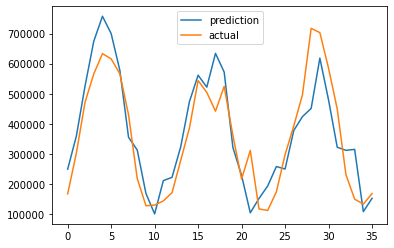

In [22]:
comparison = pd.DataFrame(predictions)
comparison["actual"] = pd.Series(test_y, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

For my stacked LSTM model, an LSTM layer required 3-D input. By default, LSTMs produce 2-D output. I need to have the LSTM output a value for each time step by setting the return_sequences paramter to True

In [23]:
# stacked LSTM

s_model = Sequential()
s_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(12, 1)))
s_model.add(LSTM(50, activation='relu'))

# the output layer predicts a single value
s_model.add(Dense(1))
s_model.compile(optimizer='adam', loss='mse')
s_model.fit(train_x, train_y, epochs=200, verbose=0)

In [25]:
predictions = s_model.predict(test_x, verbose=0)

In [26]:
prediction_list = []
for num in predictions:
    prediction_list.append(num[0])
# calculate error (metric)
mape(test_y, prediction_list)

22.34551782041752

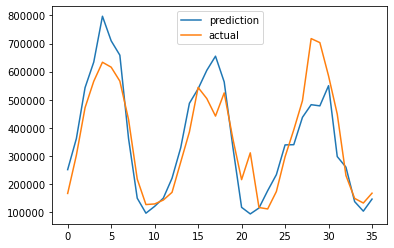

In [28]:
comparison = pd.DataFrame(predictions)
comparison["actual"] = pd.Series(test_y, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

Next, I try a bidirectional LSTM that adds a Bidirectional wrapper layer to the first hidden layer.

In [29]:
# bidirectional LSTM
b_model = Sequential()
b_model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(12, 1))))

# the output layer predicts a single value
b_model.add(Dense(1))
b_model.compile(optimizer='adam', loss='mse')
b_model.fit(train_x, train_y, epochs=200, verbose=0)

In [32]:
predictions = b_model.predict(test_x, verbose=0)

prediction_list = []
for num in predictions:
    prediction_list.append(num[0])
# calculate error (metric)
mape(test_y, prediction_list)

25.73407685994412

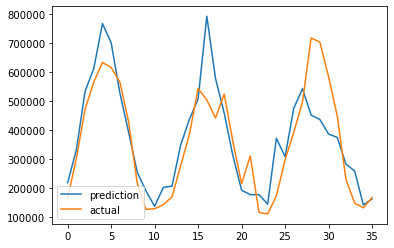

In [34]:
comparison = pd.DataFrame(predictions)
comparison["actual"] = pd.Series(test_y, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

Next, I try a hybrid CNN LSTM. The input data for a CNN needs to have the following structure: [samples, subsequences, timesteps, features]. Therefore, I need to prepare my data slightly differently.

In [35]:
train_x, train_y = split_data(park_train["num_visitors"].tolist(), 12)
test_x, test_y = split_data(park_test["num_visitors"].tolist(), 12)

n_features = 1
n_seq = 4 # for each sequence of 12, split into 4 samples with 3 sub-samples each
n_steps = 3

train_x = train_x.reshape(train_x.shape[0], n_seq, n_steps, n_features)
test_x = test_x.reshape(test_x.shape[0], n_seq, n_steps, n_features)

In [36]:
# define the CNN LSTM
c_model = Sequential()
c_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
c_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
c_model.add(TimeDistributed(Flatten()))
c_model.add(LSTM(50, activation='relu'))
c_model.add(Dense(1))
c_model.compile(optimizer='adam', loss='mse')
c_model.fit(train_x, train_y, epochs=200, verbose=0)

In [39]:
predictions = c_model.predict(test_x, verbose=0)
prediction_list = []
for num in predictions:
    prediction_list.append(num[0])
# calculate error (metric)
mape(test_y, prediction_list)

18.35867980423688

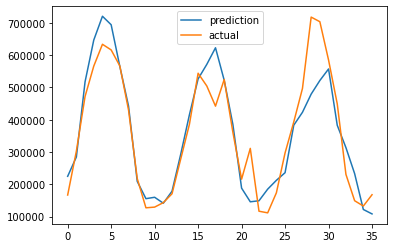

In [41]:
comparison = pd.DataFrame(predictions)
comparison["actual"] = pd.Series(test_y, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();